# Central Model Evaluation Part 1

The central model is evaluated for the cincinnati dataset.
Especially the prediction results and patterns learned by the deep learning algorithm are analyzed.

## Imports

In [1]:
import collections
import functools
import os
import time

import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import feature_column
from tensorflow.keras import layers
from tqdm import tqdm
import import_ipynb

In [2]:
from model_helper import ModelHelper

importing Jupyter notebook from model_helper.ipynb


## DataSet

Only a single vehicle is used here as the whole dataset contains over 14 million rows.
As a result, executing training on the full dataset takes a very long time.

In [3]:
df = pd.read_csv("./cincinnati/cincinatti_zones_153.csv")
df.head(10)

,location_id,vehicle_id,is_weekend,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,4,153,False,-0.725424,-0.688302,0.743145,0.669131,0.5,0.866025,0.0,1.0
1,10,153,False,-0.619379,-0.785092,0.743145,0.669131,0.5,0.866025,0.0,1.0
2,4,153,False,0.378379,-0.925651,0.743145,0.669131,0.5,0.866025,0.0,1.0
3,4,153,False,0.635798,-0.771856,0.743145,0.669131,0.5,0.866025,0.0,1.0
4,11,153,False,-0.492424,-0.870356,0.743145,0.669131,0.5,0.866025,0.0,1.0
5,4,153,False,0.476903,-0.878956,0.743145,0.669131,0.5,0.866025,0.0,1.0
6,18,153,False,-0.697999,-0.716099,0.743145,0.669131,0.5,0.866025,0.0,1.0
7,10,153,False,0.121725,-0.992564,0.743145,0.669131,0.5,0.866025,0.0,1.0
8,10,153,False,0.004363,-0.999990,0.743145,0.669131,0.5,0.866025,0.0,1.0
9,13,153,False,0.618923,-0.785452,0.743145,0.669131,0.5,0.866025,0.0,1.0


In [4]:
df.drop(columns=['vehicle_id', 'is_weekend'], axis='columns', inplace=True)
df

,location_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,4,-0.725424,-0.688302,0.743145,0.669131,0.500000,0.866025,0.000000,1.000000
1,10,-0.619379,-0.785092,0.743145,0.669131,0.500000,0.866025,0.000000,1.000000
2,4,0.378379,-0.925651,0.743145,0.669131,0.500000,0.866025,0.000000,1.000000
3,4,0.635798,-0.771856,0.743145,0.669131,0.500000,0.866025,0.000000,1.000000
4,11,-0.492424,-0.870356,0.743145,0.669131,0.500000,0.866025,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
165636,0,-0.108939,-0.994048,-0.587785,0.809017,-0.500000,-0.866025,0.781831,0.623490
165637,0,-0.083026,-0.996547,0.743145,0.669131,-0.866025,-0.500000,0.974928,-0.222521
165638,1,0.321302,-0.946977,0.207912,0.978148,-0.500000,-0.866025,-0.974928,-0.222521
165639,1,-0.933554,0.358436,0.743145,0.669131,-0.866025,-0.500000,0.974928,-0.222521


In [5]:
''# the number of different locations defines the vocabulary size
locations = df.location_id
vocab_size = locations.nunique()
print('vocabulary size:', vocab_size)

vocabulary size: 47


Re-assign the ids to only use values from 0 to 46.

In [6]:
df['location_id'] = df.groupby('location_id', sort=False).ngroup()
df.head(10)

,location_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,0,-0.725424,-0.688302,0.743145,0.669131,0.5,0.866025,0.0,1.0
1,1,-0.619379,-0.785092,0.743145,0.669131,0.5,0.866025,0.0,1.0
2,0,0.378379,-0.925651,0.743145,0.669131,0.5,0.866025,0.0,1.0
3,0,0.635798,-0.771856,0.743145,0.669131,0.5,0.866025,0.0,1.0
4,2,-0.492424,-0.870356,0.743145,0.669131,0.5,0.866025,0.0,1.0
5,0,0.476903,-0.878956,0.743145,0.669131,0.5,0.866025,0.0,1.0
6,3,-0.697999,-0.716099,0.743145,0.669131,0.5,0.866025,0.0,1.0
7,1,0.121725,-0.992564,0.743145,0.669131,0.5,0.866025,0.0,1.0
8,1,0.004363,-0.999990,0.743145,0.669131,0.5,0.866025,0.0,1.0
9,4,0.618923,-0.785452,0.743145,0.669131,0.5,0.866025,0.0,1.0


Init the ModelHelper and set all needed parameters such as the different column_names and the vocab_size.

In [7]:
mh = ModelHelper(df, 17)

In [8]:
mh.set_target_column_name('location_id')
mh.set_vocab_size(vocab_size)
numerical_column_names = ['clock_sin', 'clock_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'week_day_sin', 'week_day_cos']
column_names = ['location_id'] + numerical_column_names
mh.set_column_names(column_names)
mh.set_numerical_column_names(numerical_column_names)

Split the data inti train, val, test.

In [9]:
# Call the function
mh.train_val_test_split()
print(len(mh.df_train), 'train examples')
print(len(mh.df_val), 'validation examples')
print(len(mh.df_test), 'test examples')

106009 train examples
26503 validation examples
33129 test examples


In [10]:
mh.split_data()
print(len(mh.list_test))
mh.list_test[0]

1949


,location_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
132512,34,-0.915429,-0.402480,0.951057,-0.309017,-0.5,-0.866025,-0.433884,-0.900969
132513,8,-0.999767,-0.021597,0.951057,-0.309017,-0.5,-0.866025,-0.433884,-0.900969
132514,15,0.186524,-0.982450,0.951057,-0.309017,-0.5,-0.866025,-0.433884,-0.900969
132515,4,-0.694815,-0.719188,0.951057,-0.309017,-0.5,-0.866025,-0.433884,-0.900969
132516,4,-0.865989,0.500063,0.994522,-0.104528,-0.5,-0.866025,0.433884,-0.900969
132517,12,0.216298,-0.976327,0.951057,-0.309017,-0.5,-0.866025,-0.433884,-0.900969
132518,10,-0.026468,-0.999650,0.951057,-0.309017,-0.5,-0.866025,-0.433884,-0.900969
132519,18,-0.978986,0.203927,0.951057,-0.309017,-0.5,-0.866025,-0.433884,-0.900969
132520,8,-0.918734,0.394877,0.994522,-0.104528,-0.5,-0.866025,0.433884,-0.900969
132521,8,-0.995792,0.091646,0.951057,-0.309017,-0.5,-0.866025,-0.433884,-0.900969


Create the final datasets for training.

In [11]:
mh.set_batch_size(16)
mh.create_and_batch_datasets(multi_target=False)

In [12]:
mh.test_dataset

<BatchDataset shapes: (OrderedDict([(location_id, (16, 16)), (clock_sin, (16, 16)), (clock_cos, (16, 16)), (day_sin, (16, 16)), (day_cos, (16, 16)), (month_sin, (16, 16)), (month_cos, (16, 16)), (week_day_sin, (16, 16)), (week_day_cos, (16, 16))]), (16,)), types: (OrderedDict([(location_id, tf.int32), (clock_sin, tf.float64), (clock_cos, tf.float64), (day_sin, tf.float64), (day_cos, tf.float64), (month_sin, tf.float64), (month_cos, tf.float64), (week_day_sin, tf.float64), (week_day_cos, tf.float64)]), tf.int64)>

In [13]:
# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units1 = 256
rnn_units2 = 128

# Create a model
def create_keras_model():
  N = mh.total_window_length
  batch_size = mh.batch_size
  number_of_places = mh.vocab_size

  # Shortcut to the layers package
  l = tf.keras.layers

  # List of numeric feature columns to pass to the DenseLayer
  numeric_feature_columns = []

  # Handling numerical columns
  for header in numerical_column_names:
	# Append all the numerical columns defined into the list
    numeric_feature_columns.append(feature_column.numeric_column(header, shape=N-1))

  feature_inputs={}
  for c_name in numerical_column_names:
    feature_inputs[c_name] = tf.keras.Input((N-1,), batch_size=batch_size, name=c_name)

  # We cannot use an array of features as always because we have sequences
  # We have to do one by one in order to match the shape
  num_features = []
  for c_name in numerical_column_names:
    f =  feature_column.numeric_column(c_name, shape=(N-1))
    feature = l.DenseFeatures(f)(feature_inputs)
    feature = tf.expand_dims(feature, -1)
    num_features.append(feature)

  # Declare the dictionary for the categories sequence as before
  sequence_input = {
      'location_id': tf.keras.Input((N-1,), batch_size=batch_size, dtype=tf.dtypes.int32, name='location_id') # add batch_size=batch_size in case of stateful GRU
  }

  # Handling the categorical feature sequence using one-hot
  location_one_hot = feature_column.sequence_categorical_column_with_vocabulary_list(
      'location_id', [i for i in range(number_of_places)])

  # one-hot encoding
  location_feature = feature_column.embedding_column(location_one_hot, embedding_dim)

  # With an input sequence we can't use the DenseFeature layer, we need to use the SequenceFeatures
  sequence_features, sequence_length = tf.keras.experimental.SequenceFeatures(location_feature)(sequence_input)


  input_sequence = l.Concatenate(axis=2)([sequence_features] + num_features)

  # Rnn
  recurrent = l.GRU(rnn_units1,
                    batch_size=batch_size, #in case of stateful
                    return_sequences=True,
                    stateful=True,
                    recurrent_initializer='glorot_uniform')(input_sequence)

  recurrent_2 = l.GRU(rnn_units2,
                      batch_size=batch_size, #in case of stateful
                      stateful=True,
                      recurrent_initializer='glorot_uniform')(recurrent)


  # Softmax output layer
  # Last layer with an output for each places
  output = layers.Dense(number_of_places, activation='softmax')(recurrent_2)


  # To return the Model, we need to define its inputs and outputs
  # In out case, we need to list all the input layers we have defined
  inputs = list(feature_inputs.values()) + list(sequence_input.values())

  # Return the Model
  return tf.keras.Model(inputs=inputs, outputs=output)

In [14]:
# Get the model and compile it
mh.assign_model(create_keras_model())
mh.compile_model()

In [15]:
mh.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(16, 16)]           0                                            
_______________________________________________________________________________________

In [16]:
mh.set_num_epochs(10)
mh.fit_model()

Epoch 1/10
389/389 [==============================] - 5s 12ms/step - loss: 2.2953 - sparse_categorical_accuracy: 0.2696 - val_loss: 2.6041 - val_sparse_categorical_accuracy: 0.1946
Epoch 2/10
389/389 [==============================] - 4s 10ms/step - loss: 2.0474 - sparse_categorical_accuracy: 0.2897 - val_loss: 2.3457 - val_sparse_categorical_accuracy: 0.2262
Epoch 3/10
389/389 [==============================] - 4s 10ms/step - loss: 1.9484 - sparse_categorical_accuracy: 0.3049 - val_loss: 2.3254 - val_sparse_categorical_accuracy: 0.2726
Epoch 4/10
389/389 [==============================] - 4s 10ms/step - loss: 1.9000 - sparse_categorical_accuracy: 0.3115 - val_loss: 2.2564 - val_sparse_categorical_accuracy: 0.2809
Epoch 5/10
389/389 [==============================] - 4s 11ms/step - loss: 1.8411 - sparse_categorical_accuracy: 0.3229 - val_loss: 2.2602 - val_sparse_categorical_accuracy: 0.2468
Epoch 6/10
389/389 [==============================] - 4s 10ms/step - loss: 1.7872 - sparse_cate

In [17]:
mh.evaluate_model()

121/121 [==============================] - 0s 3ms/step - loss: 2.3861 - sparse_categorical_accuracy: 0.2314


## Evaluation of the model prediction

A manual evaluation of the model prediction is executed.
An attempt is made to understand patterns that the model has learned to reach a good prediction quality.
In case of the original NYC dataset, the evaluation showed that in most cases the network simply predicts the taxi to not leave the current area.
As a result, a high prediction quality of around 30 percent could be reached.
It is interesting to see whether this also applies to the public service vehicles of cincinnati.

Manually predict the logits for the test dataset.

In [18]:
def print_info(T):
    print('Element #0:', T[0])
    print('Shape:', T.shape)

In [19]:
logits = mh.model.predict(mh.test_dataset)
print_info(logits)

Element #0: [1.5779789e-01 8.6400518e-03 3.3591256e-02 3.5335708e-02 2.3391938e-01
 4.9316944e-03 3.8361538e-02 9.4749773e-04 1.9313370e-01 5.2714944e-03
 1.5080664e-02 3.1134116e-02 2.6837127e-02 5.6308345e-03 4.3775993e-03
 4.1867230e-02 1.5379529e-03 2.8248546e-03 8.0214463e-02 3.1830378e-02
 3.0183436e-03 1.0587412e-03 4.3323231e-05 1.1376197e-03 1.3958429e-03
 4.8936796e-03 6.3284539e-04 1.9588647e-04 1.4044581e-03 5.8650807e-03
 5.8861189e-03 7.9474994e-04 9.2839153e-04 1.6231965e-03 9.1855596e-05
 7.8151684e-04 1.0643650e-03 5.2420544e-03 2.2940534e-04 2.8617682e-03
 5.4990719e-03 5.6080633e-05 1.2792854e-03 5.2682275e-04 1.7947299e-05
 1.4406016e-04 6.2045532e-05]
Shape: (1936, 47)


Apply the softmax activation function.

In [20]:
predictions = tf.nn.softmax(logits, axis=1)
print_info(predictions)

Element #0: tf.Tensor(
[0.0243586  0.02098331 0.02151345 0.02155101 0.02628521 0.02090564
 0.02161632 0.02082251 0.02523472 0.02091274 0.02111889 0.02146066
 0.02136864 0.02092026 0.02089406 0.02169224 0.02083481 0.02086164
 0.02254023 0.0214756  0.02086568 0.02082483 0.02080369 0.02082647
 0.02083185 0.02090484 0.02081596 0.02080687 0.02083203 0.02092516
 0.0209256  0.02081933 0.02082211 0.02083659 0.0208047  0.02081906
 0.02082494 0.02091213 0.02080756 0.02086241 0.0209175  0.02080396
 0.02082942 0.02081375 0.02080316 0.02080579 0.02080408], shape=(47,), dtype=float32)
Shape: (1936, 47)


Use argmax to obtain the predicted classes.

In [21]:
predicted_classes = np.argmax(predictions, 1)
print_info(predicted_classes)

Element #0: 4
Shape: (1936,)


Obtain the actual values of the test_dataset by unbatching and create an array containing these.
Then compute the difference in predictions and actual values.

In [22]:
actual_values = []
X_loc = []
for x, y in mh.test_dataset.unbatch():
    actual_values.append(y.numpy())
    X_loc.append(x['location_id'].numpy())

actual_values = np.array(actual_values)
X_loc = np.array(X_loc)

diff = actual_values - predicted_classes
print(diff.shape)
unique, counts = np.unique(diff, return_counts=True)

print('actual_values')
print_info(actual_values)
print('predicted_classes')
print_info(predicted_classes)
print('diff')
print_info(diff)

(1936,)
actual_values
Element #0: 11
Shape: (1936,)
predicted_classes
Element #0: 4
Shape: (1936,)
diff
Element #0: 7
Shape: (1936,)


Sanity check the results, compute the accuracy (should be roughly the same) by comparing the wrong and correct  predictions

In [23]:
wrong = np.count_nonzero(diff)
size = diff.shape[0]
correct =  size - wrong
acc = correct / size
print('# correct Predictions : ', correct)
print('# wrong Predictions : ', wrong)
print('accuracy: ', acc)

# correct Predictions :  447
# wrong Predictions :  1489
accuracy:  0.2308884297520661


Show the predicted classes and their prediction counts.

In [24]:
res = pd.DataFrame(predicted_classes)
unique, counts = np.unique(res, return_counts=True)
print(unique)
print(counts)

[ 0  4  8 11 12 13 14 15 17 18 20 24]
[711 691 410  70   7   2   7   6   1  29   1   1]


Only 7 of the 47 classes were predicted by the model.

In [25]:
res = pd.DataFrame(actual_values)
unique, counts = np.unique(res, return_counts=True)
print(unique)
print(counts)

[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 24 28 29
 30 34 35 36 37 38 39 42 43]
[390  24  19  13 406  66  42 332 105  46  10  26  33   5  56   6 222  27
  22   3   1  25   9  18   9   2   1   2   4   3   1   6   2]


Next, take a look at some exemplary predictions:

In [26]:
for i in range(0,20):
    print('Prediction #', i)
    print('Actual value: ', actual_values[i])
    print('Predicted value: ', predicted_classes[i])

Prediction # 0
Actual value:  11
Predicted value:  4
Prediction # 1
Actual value:  0
Predicted value:  0
Prediction # 2
Actual value:  15
Predicted value:  8
Prediction # 3
Actual value:  0
Predicted value:  0
Prediction # 4
Actual value:  8
Predicted value:  4
Prediction # 5
Actual value:  20
Predicted value:  15
Prediction # 6
Actual value:  17
Predicted value:  8
Prediction # 7
Actual value:  0
Predicted value:  4
Prediction # 8
Actual value:  0
Predicted value:  0
Prediction # 9
Actual value:  8
Predicted value:  4
Prediction # 10
Actual value:  15
Predicted value:  0
Prediction # 11
Actual value:  15
Predicted value:  15
Prediction # 12
Actual value:  3
Predicted value:  4
Prediction # 13
Actual value:  8
Predicted value:  4
Prediction # 14
Actual value:  15
Predicted value:  0
Prediction # 15
Actual value:  28
Predicted value:  4
Prediction # 16
Actual value:  4
Predicted value:  4
Prediction # 17
Actual value:  8
Predicted value:  0
Prediction # 18
Actual value:  0
Predicted val

Create a matrix for the x and y values by concatenation.
The rows contain all 16 locations used for the prediction.

In [27]:
Y = np.expand_dims(actual_values, -1)
print('X_loc.shape ', X_loc.shape)
print('Y.shape ', Y.shape)
X_Y = np.concatenate((X_loc, Y), axis=1)
print('X_Y.shape: ', X_Y.shape)
X_Y[:10]

X_loc.shape  (1936, 16)
Y.shape  (1936, 1)
X_Y.shape:  (1936, 17)


array([[34,  8, 15,  4,  4, 12, 10, 18,  8,  8, 15,  4,  8,  3, 12,  4,
        11],
       [ 8,  4, 18,  0, 46,  3,  4,  8, 12, 15, 15,  4,  3,  4, 12, 17,
         0],
       [ 4, 17,  8, 15, 24,  4, 24,  8, 15,  0,  8,  8, 20,  0,  8, 12,
        15],
       [24,  8,  0, 12,  4,  0, 37, 24,  0,  0, 24, 18, 15, 10, 15,  8,
         0],
       [37,  8,  4,  8, 18, 15,  4,  8,  4,  0, 18, 15,  8,  8, 15, 24,
         8],
       [ 4, 15,  0, 37,  6,  8, 37, 37, 18, 29,  0,  0, 17, 12, 12, 15,
        20],
       [15,  8,  0, 18,  4,  0, 18, 16,  8, 24,  0, 18,  8,  8, 15, 15,
        17],
       [12,  4, 11, 15, 24,  4, 24, 46,  8, 10,  0, 37, 15,  4,  0,  0,
         0],
       [46,  0,  0, 24,  8,  4,  0, 15,  0, 11,  0, 24,  0, 15,  0, 15,
         0],
       [ 8, 12,  0,  0,  0,  4, 24,  4,  8,  4,  0,  0,  4, 12,  4,  4,
         8]], dtype=int64)

Create an array of column names.

In [28]:
columns = []
for i in range(0,16):
    columns.append('loc_' + str(i))
columns.append('y_true')
columns

['loc_0',
 'loc_1',
 'loc_2',
 'loc_3',
 'loc_4',
 'loc_5',
 'loc_6',
 'loc_7',
 'loc_8',
 'loc_9',
 'loc_10',
 'loc_11',
 'loc_12',
 'loc_13',
 'loc_14',
 'loc_15',
 'y_true']

Assign the column names and create a pandas dataframe.

In [29]:
df = pd.DataFrame(X_Y, columns = columns)
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,loc_11,loc_12,loc_13,loc_14,loc_15,y_true
0,34,8,15,4,4,12,10,18,8,8,15,4,8,3,12,4,11
1,8,4,18,0,46,3,4,8,12,15,15,4,3,4,12,17,0
2,4,17,8,15,24,4,24,8,15,0,8,8,20,0,8,12,15
3,24,8,0,12,4,0,37,24,0,0,24,18,15,10,15,8,0
4,37,8,4,8,18,15,4,8,4,0,18,15,8,8,15,24,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,2,8,0,0,0,0,4,0,8,9,4,13,8,0,0,2,8
1932,0,0,4,4,29,8,18,18,18,24,8,6,0,18,9,6,7
1933,18,18,4,18,9,0,18,8,6,0,0,4,4,4,1,8,0
1934,4,4,4,0,18,18,0,18,8,4,18,8,4,9,15,18,4


Add the predicted classes.

In [30]:
df['y_pred'] = predicted_classes
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,loc_11,loc_12,loc_13,loc_14,loc_15,y_true,y_pred
0,34,8,15,4,4,12,10,18,8,8,15,4,8,3,12,4,11,4
1,8,4,18,0,46,3,4,8,12,15,15,4,3,4,12,17,0,0
2,4,17,8,15,24,4,24,8,15,0,8,8,20,0,8,12,15,8
3,24,8,0,12,4,0,37,24,0,0,24,18,15,10,15,8,0,0
4,37,8,4,8,18,15,4,8,4,0,18,15,8,8,15,24,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,2,8,0,0,0,0,4,0,8,9,4,13,8,0,0,2,8,0
1932,0,0,4,4,29,8,18,18,18,24,8,6,0,18,9,6,7,0
1933,18,18,4,18,9,0,18,8,6,0,0,4,4,4,1,8,0,4
1934,4,4,4,0,18,18,0,18,8,4,18,8,4,9,15,18,4,8


Add a column "correct" that displays whether the prediction was correct or not.

In [31]:
df['correct'] = df['y_true'] - df['y_pred']

def reduce01 (val):
    if val == 0:
        return True
    else:
        return False

df['correct'] = df['correct'].map(reduce01)
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,loc_11,loc_12,loc_13,loc_14,loc_15,y_true,y_pred,correct
0,34,8,15,4,4,12,10,18,8,8,15,4,8,3,12,4,11,4,False
1,8,4,18,0,46,3,4,8,12,15,15,4,3,4,12,17,0,0,True
2,4,17,8,15,24,4,24,8,15,0,8,8,20,0,8,12,15,8,False
3,24,8,0,12,4,0,37,24,0,0,24,18,15,10,15,8,0,0,True
4,37,8,4,8,18,15,4,8,4,0,18,15,8,8,15,24,8,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,2,8,0,0,0,0,4,0,8,9,4,13,8,0,0,2,8,0,False
1932,0,0,4,4,29,8,18,18,18,24,8,6,0,18,9,6,7,0,False
1933,18,18,4,18,9,0,18,8,6,0,0,4,4,4,1,8,0,4,False
1934,4,4,4,0,18,18,0,18,8,4,18,8,4,9,15,18,4,8,False


Fill missing rows and columns in order to have a full matrix of NxN with N being the number of unique predictions.

In [32]:
def fill_missing(df, matrix, column_name):
    columns = set(df['y_pred'].values) | set(df[column_name].values)
    columns = list(columns)
    matrix = matrix.reindex(columns = columns)
    matrix = np.transpose(matrix)
    matrix = matrix.reindex(columns = columns)
    matrix = np.transpose(matrix)
    matrix[np.isnan(matrix)] = 0
    return matrix

First, check whether the network also predicts the last location as the next location in most cases.

In [33]:
matrix = df.groupby(['y_pred', 'loc_15']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'loc_15')
matrix

y_pred,0,1,2,3,4,6,7,8,9,10,...,29,30,34,35,36,37,38,39,42,43
loc_15,,,,,,,,,,,,,,,,,,,,,
0,206.0,0.0,0.0,0.0,118.0,0.0,0.0,71.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.0,0.0,0.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,84.0,0.0,0.0,0.0,231.0,0.0,0.0,84.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,44.0,0.0,0.0,0.0,13.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,25.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,121.0,0.0,0.0,0.0,87.0,0.0,0.0,114.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,33.0,0.0,0.0,0.0,33.0,0.0,0.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Define custom color coding for the heatmap.

In [34]:
from colour import Color
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

def make_Ramp( ramp_colors ):

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp( ['#ffffff', '#5ede00', '#d24e01', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000'] )

Plot the matrix of the first analysis.

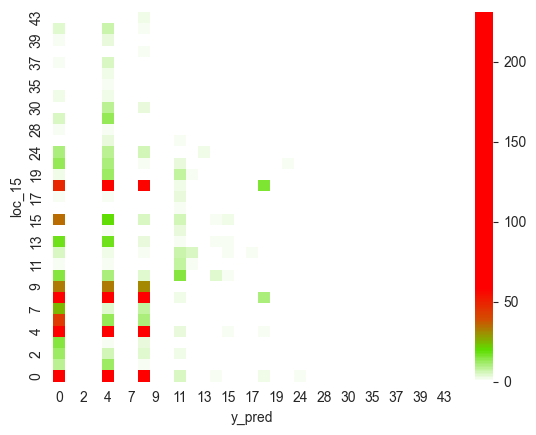

In [35]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

It can be seen that in case of the cincinnati data, the network does not learn to predict the last location as the next location.
This is a more satisfying result.
The model seems to be able to learn a pattern for the vehicle used in the training dataset.

Use the first location to create the matrix and plot the heatmap.

In [36]:
matrix = df.groupby(['y_pred', 'loc_0']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'loc_0')
matrix

y_pred,0,1,2,3,4,6,7,8,9,10,...,29,30,34,35,36,37,39,42,43,46
loc_0,,,,,,,,,,,,,,,,,,,,,
0,192.0,0.0,0.0,0.0,152.0,0.0,0.0,64.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.0,0.0,0.0,0.0,6.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,114.0,0.0,0.0,0.0,160.0,0.0,0.0,101.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,23.0,0.0,0.0,0.0,23.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,16.0,0.0,0.0,0.0,11.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,119.0,0.0,0.0,0.0,100.0,0.0,0.0,75.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,35.0,0.0,0.0,0.0,38.0,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


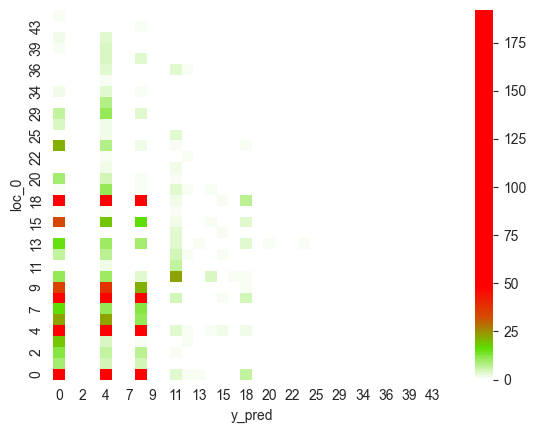

In [37]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

The first location is also not used as the main indication for the prediction.

Next, the predicted and true values are mapped as a heatmap.

In [38]:
matrix = df.groupby(['y_pred', 'y_true']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'y_true')
matrix

y_pred,0,1,2,3,4,6,7,8,9,10,...,29,30,34,35,36,37,38,39,42,43
y_true,,,,,,,,,,,,,,,,,,,,,
0,168.0,0.0,0.0,0.0,133.0,0.0,0.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.0,0.0,0.0,0.0,7.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,138.0,0.0,0.0,0.0,167.0,0.0,0.0,90.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,22.0,0.0,0.0,0.0,28.0,0.0,0.0,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,18.0,0.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,120.0,0.0,0.0,0.0,105.0,0.0,0.0,99.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,38.0,0.0,0.0,0.0,43.0,0.0,0.0,22.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


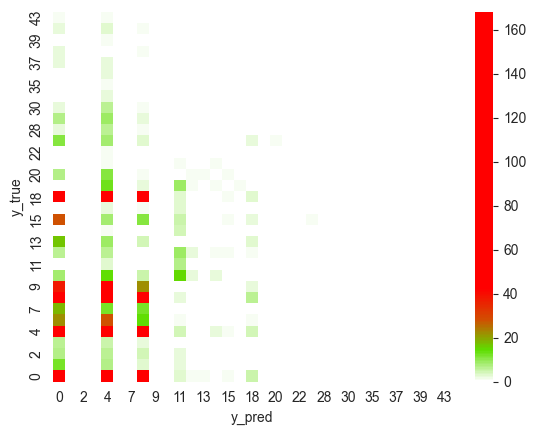

In [39]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

The most correct prediction occur for classes 0, 4, 8 and 12.